# Electric Field & GIC Geographic Analysis

This notebook demonstrates the complete GIC workflow on a geographic coordinate
system: building a 2D electric field grid aligned to a PowerWorld case's
geographic extent, visualizing E-field vectors over state borders and
transmission lines, computing GIC, and exporting to B3D format.

Topics covered:
- Extracting geographic extent from bus/substation coordinates
- Building a Grid2D on lat/lon coordinates
- Defining and computing electric fields on geographic grids
- Vector field visualization over geographic maps with state borders
- Transmission line and bus location overlays
- GIC computation from spatially-varying E-fields
- B3D file export for PowerWorld import
- Multiple visualization styles: heatmap, vector field, tiles

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from esapp import GridWorkBench
from esapp.components import Branch, Bus, Substation, GICXFormer
from esapp.utils import (
    Grid2D, B3D,
    format_plot, plot_vecfield, plot_lines,
    border, darker_hsv_colormap,
)

In [2]:
# This cell is hidden in the documentation.
import ast

with open('../data/case_B.txt', 'r') as f:
    case_path = ast.literal_eval(f.read().strip())

wb = GridWorkBench(case_path)

# Configure geographic border shape ('US', 'Texas', etc.)
SHAPE = 'Texas'

'open' took: 3.8562 sec


In [3]:
# Plotting functions (hidden from documentation)
import sys; sys.path.insert(0, "..")
from plot_helpers import (
    plot_geo_grid_buses, plot_efield_comparison, plot_efield_vectors,
    plot_network_efield, plot_barh_top, plot_gic_geo_map,
    plot_direction_sensitivity, plot_b3d_roundtrip,
)

Import the case and instantiate the `GridWorkBench`.

```python
from esapp import GridWorkBench
wb = GridWorkBench(case_path)
```

## 1. Extracting Geographic Extent

We extract bus coordinates from the case and determine the geographic bounding box
that will define our E-field computation grid.

In [4]:
# Get bus coordinates
lon, lat = wb.buscoords()

# Determine geographic bounding box with padding
pad = 0.5  # degrees padding
lon_min, lon_max = lon.min() - pad, lon.max() + pad
lat_min, lat_max = lat.min() - pad, lat.max() + pad

print(f"Geographic extent:")
print(f"  Longitude: {lon_min:.2f} to {lon_max:.2f}")
print(f"  Latitude:  {lat_min:.2f} to {lat_max:.2f}")
print(f"  Number of buses: {len(lon)}")

Geographic extent:
  Longitude: -105.12 to -93.87
  Latitude:  25.41 to 36.33
  Number of buses: 2000


## 2. Building a Geographic E-Field Grid

We construct a 2D grid in latitude/longitude space covering the case's geographic
footprint. Each grid point will hold Ex and Ey components of the electric field in V/km.

In [ ]:
# Grid resolution
nx, ny = 40, 30

# Coordinate arrays
lons = np.linspace(lon_min, lon_max, nx)
lats = np.linspace(lat_min, lat_max, ny)
LON, LAT = np.meshgrid(lons, lats)

# Grid2D for finite difference operators if needed
grid = Grid2D((nx, ny))

print(f"Grid: {nx} x {ny} = {grid.size} points")
print(f"Edges: {grid.n_edges} (horizontal: {grid.n_edges_x}, vertical: {grid.n_edges_y})")
print(f"Resolution: {(lon_max - lon_min) / nx:.3f} deg lon x {(lat_max - lat_min) / ny:.3f} deg lat")

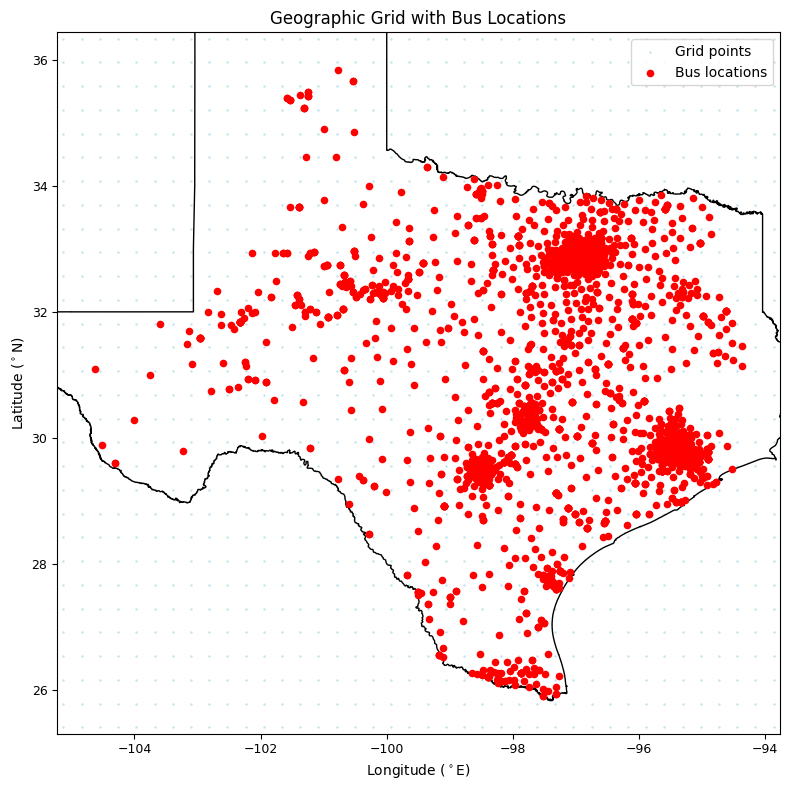

In [6]:
plot_geo_grid_buses(LON, LAT, lon, lat, SHAPE,
                    xlim=(lon_min, lon_max), ylim=(lat_min, lat_max))

## 3. Defining Electric Fields

We define several E-field patterns on the geographic grid:
1. **Uniform field** â€” constant magnitude and direction (baseline)
2. **Spatially varying field** â€” magnitude varies with latitude (models conductivity variation)
3. **Rotational field** â€” direction varies spatially

All fields are in V/km on the lat/lon grid.

In [7]:
# Uniform field: 1 V/km pointing East (Ex=1, Ey=0)
E_mag = 1.0  # V/km
E_dir = 90.0  # degrees from North (90 = East)

Ex_uniform = E_mag * np.sin(np.radians(E_dir)) * np.ones_like(LON)
Ey_uniform = E_mag * np.cos(np.radians(E_dir)) * np.ones_like(LON)

print(f"Uniform E-field: {E_mag} V/km at {E_dir} deg from North")
print(f"  Ex (Eastward)  = {Ex_uniform[0, 0]:.3f} V/km")
print(f"  Ey (Northward) = {Ey_uniform[0, 0]:.3f} V/km")

Uniform E-field: 1.0 V/km at 90.0 deg from North
  Ex (Eastward)  = 1.000 V/km
  Ey (Northward) = 0.000 V/km


In [8]:
# Latitude-dependent magnitude: stronger in the north
E_magnitude = 0.5 + 1.5 * (LAT - lat_min) / (lat_max - lat_min)  # 0.5 to 2.0 V/km

Ex_varying = E_magnitude * np.sin(np.radians(E_dir))
Ey_varying = E_magnitude * np.cos(np.radians(E_dir))

In [9]:
# Rotational field: direction varies with longitude
lon_center = (lon_min + lon_max) / 2
angle_field = np.pi / 2 + 0.5 * np.pi * (LON - lon_center) / (lon_max - lon_center)

Ex_rotational = E_mag * np.cos(angle_field)
Ey_rotational = E_mag * np.sin(angle_field)

## 4. E-Field Visualization Gallery

We demonstrate multiple visualization styles for the electric fields overlaid on geographic features.

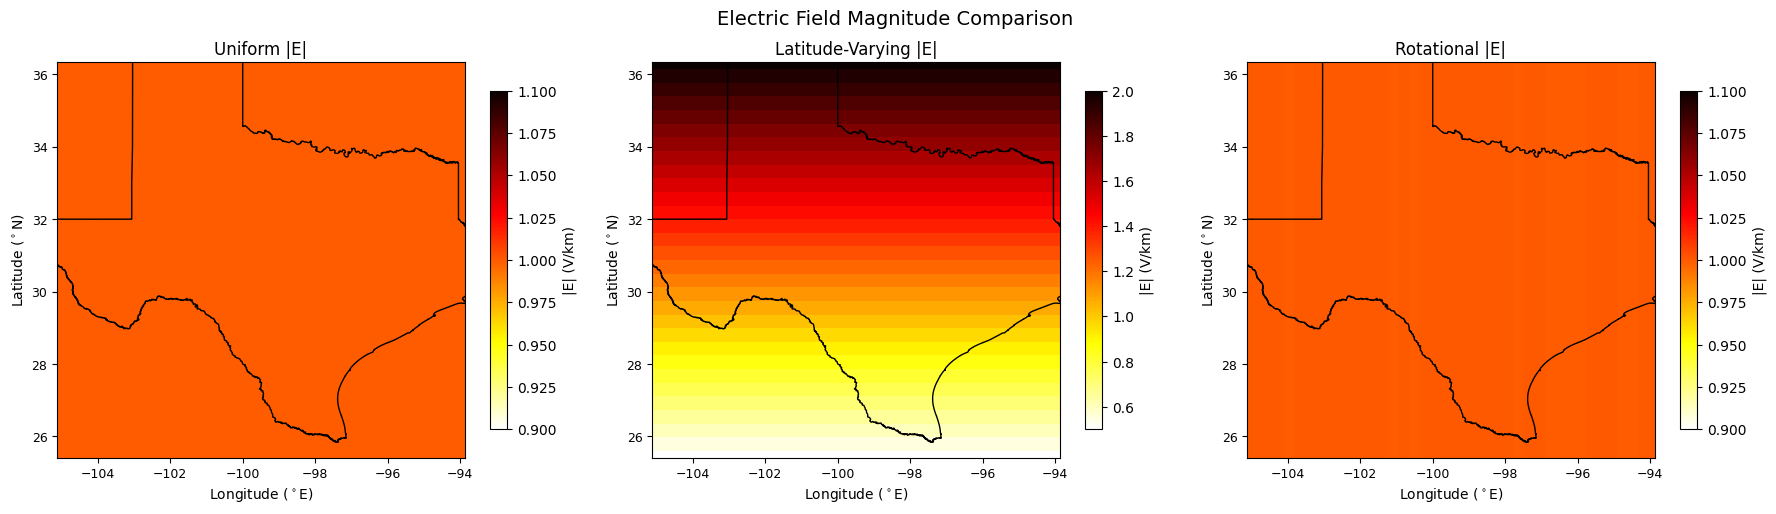

In [10]:
fields = [
    ('Uniform', Ex_uniform, Ey_uniform),
    ('Latitude-Varying', Ex_varying, Ey_varying),
    ('Rotational', Ex_rotational, Ey_rotational),
]

plot_efield_comparison(LON, LAT, fields, SHAPE)

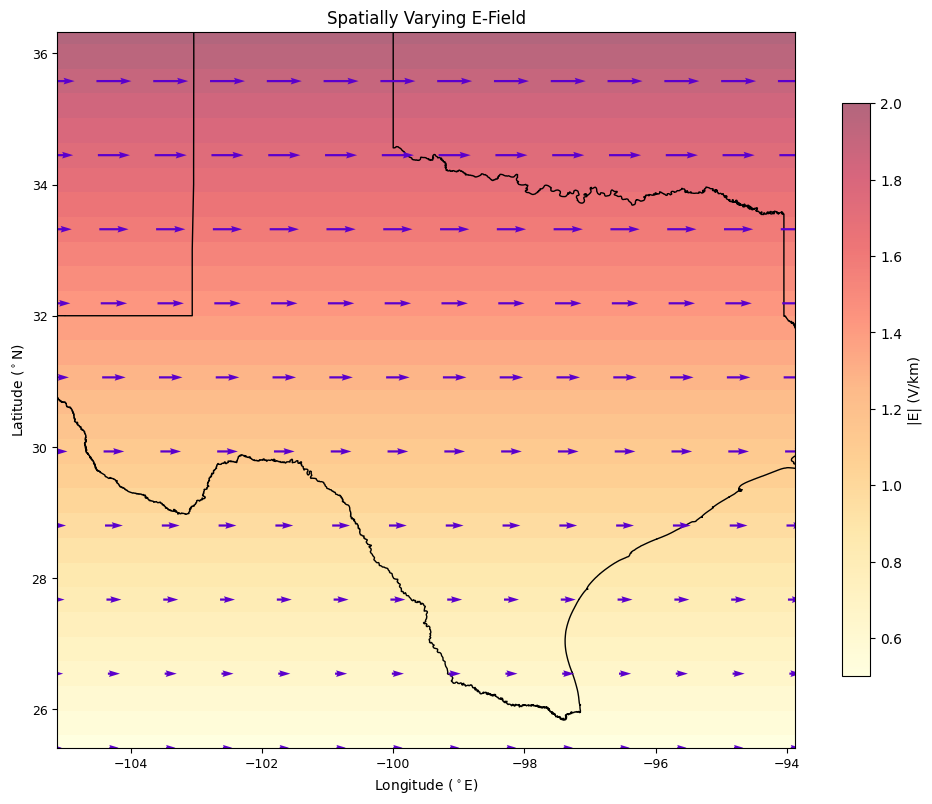

In [11]:
plot_efield_vectors(LON, LAT, Ex_varying, Ey_varying, SHAPE)

### E-Field with Transmission Network Overlay

Combine the E-field visualization with the actual transmission network from the PowerWorld case.

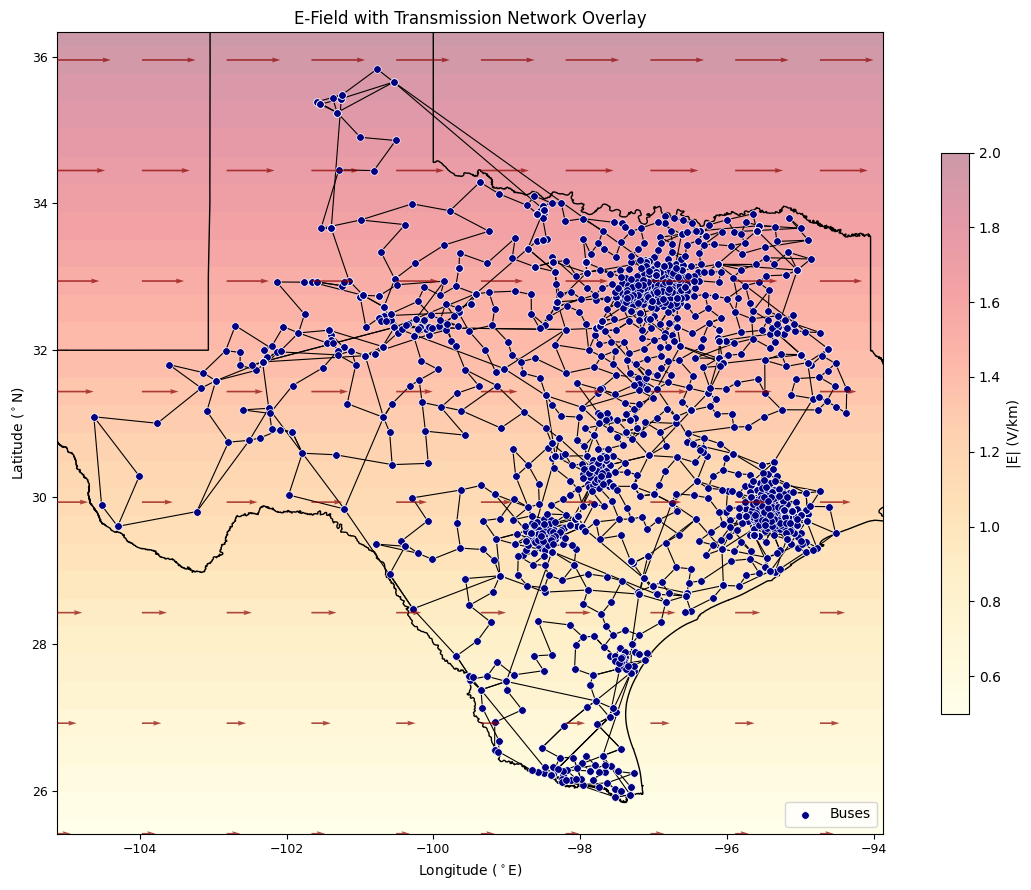

In [12]:
lines = wb[Branch, ['Longitude', 'Longitude:1', 'Latitude', 'Latitude:1']]
magnitude = np.sqrt(Ex_varying**2 + Ey_varying**2)

plot_network_efield(LON, LAT, magnitude, lines, lon, lat,
                    Ex_varying, Ey_varying, SHAPE)

## 5. Computing GIC from the E-Field

With the GIC model built from `wb.gic.model()`, we compute transformer
GICs. The storm function applies a uniform E-field and PowerWorld
computes the resulting neutral currents in each transformer.

In [13]:
# Configure and build GIC model
wb.gic.configure()
wb.gic.model()

print(f"GIC Model built:")
print(f"  G-matrix shape: {wb.gic.G.shape}")
print(f"  H-matrix shape: {wb.gic.H.shape}")
print(f"  Incidence matrix shape: {wb.gic.A.shape}")

GIC Model built:
  G-matrix shape: (3250, 3250)
  H-matrix shape: (861, 4137)
  Incidence matrix shape: (4137, 3250)


In [14]:
# Uniform storm via PowerWorld (baseline)
wb.gic.storm(1.0, 90)
gic_data = wb[GICXFormer, ['BusNum3W', 'BusNum3W:1', 'GICXFNeutralAmps']]

# Top 10 transformers by GIC magnitude
top10 = gic_data.reindex(gic_data['GICXFNeutralAmps'].abs().sort_values(ascending=False).index).head(10)
print("Top 10 Transformers by GIC (uniform 1 V/km East):")
print(top10.to_string(index=False))

Top 10 Transformers by GIC (uniform 1 V/km East):
 BusNum3W  BusNum3W:1  BusNum3W:2  BusNum3W:5  GICXFNeutralAmps LineCircuit
     1079        1071           0        1071       -122.993401           1
     7073        7074           0        7074        107.543900           1
     4146        4147           0        4147        -98.133308           1
     7047        7048           0        7048        -96.076111           1
     5045        5046           0        5046         90.701279           1
     6234        6235           0        6235        -90.185265           1
     5451        5452           0        5452        -86.951988           1
     5204        5205           0        5205        -84.667992           1
     6308        6309           0        6309        -75.916336           1
     5192        5193           0        5193        -64.725769           1


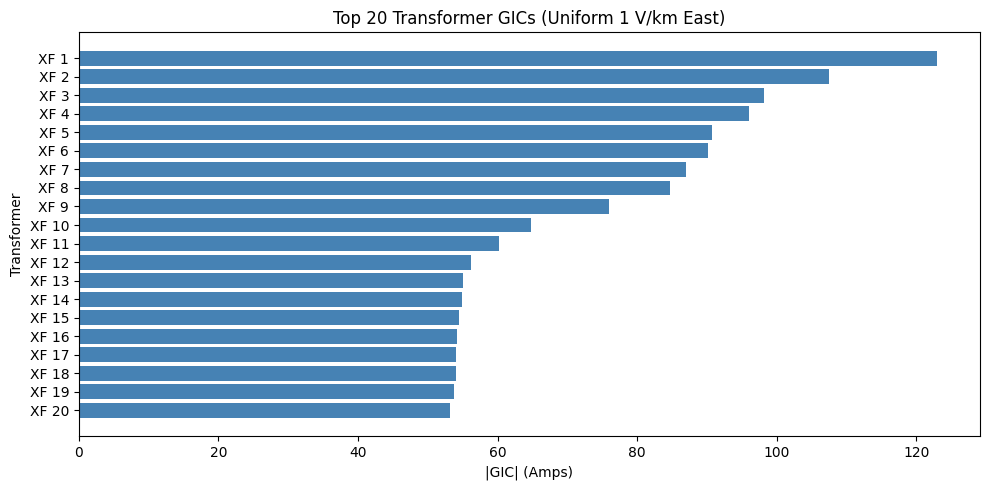

<Axes: title={'center': 'Top 20 Transformer GICs (Uniform 1 V/km East)'}, xlabel='|GIC| (Amps)', ylabel='Transformer'>

In [15]:
gic_vals = gic_data['GICXFNeutralAmps'].abs().sort_values(ascending=False).head(20)

plot_barh_top(gic_vals, labels=[f'XF {i + 1}' for i in range(len(gic_vals))],
              title='Top 20 Transformer GICs (Uniform 1 V/km East)',
              xlabel='|GIC| (Amps)', ylabel='Transformer')

## 6. GIC Results on the Geographic Map

Overlay GIC magnitudes on the transmission network map. Transformer locations are
plotted with marker size proportional to GIC magnitude.

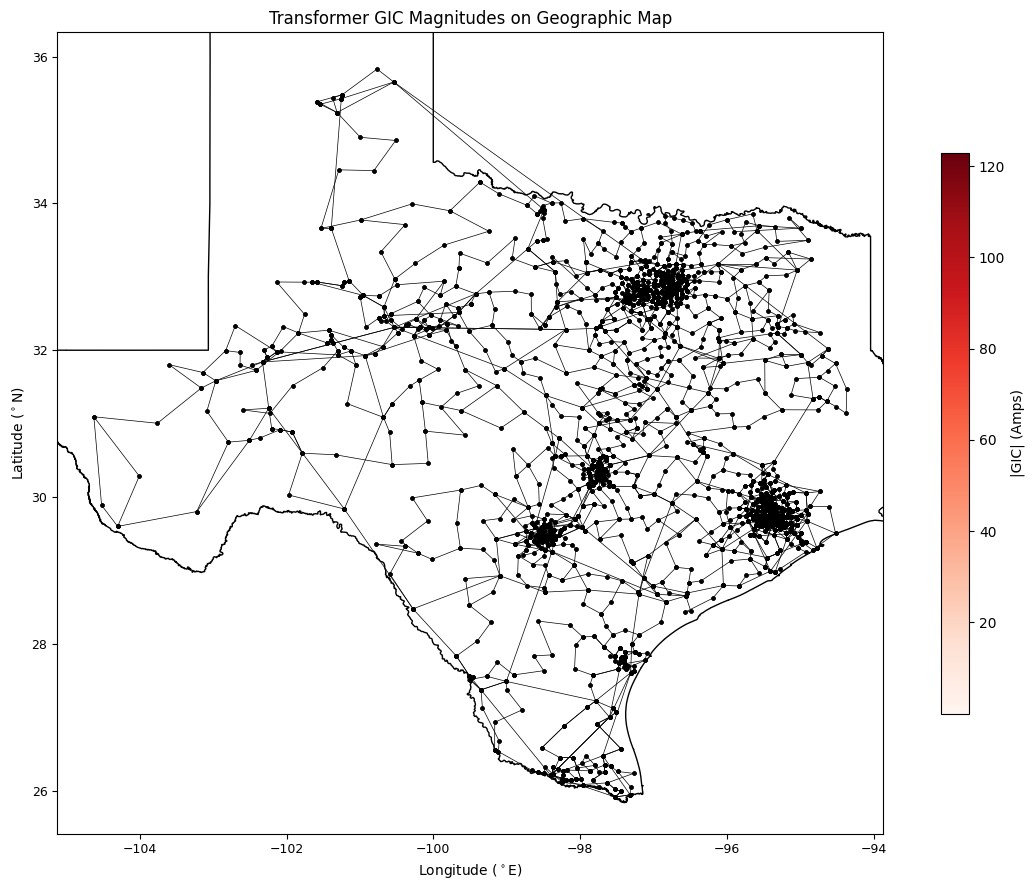

In [16]:
bus_coords = wb[Bus, ['BusNum', 'Longitude', 'Latitude']]
xf_geo = gic_data.merge(bus_coords, left_on='BusNum3W', right_on='BusNum', how='inner')
gic_mag = xf_geo['GICXFNeutralAmps'].abs()

plot_gic_geo_map(lines, xf_geo, gic_mag, SHAPE,
                 xlim=(lon_min, lon_max), ylim=(lat_min, lat_max))

## 7. Storm Direction Sensitivity

Sweep the E-field direction from 0 to 360 degrees and track the maximum GIC
at each direction. This reveals which storm orientations produce the worst-case
GIC for this network.

In [17]:
directions = np.arange(0, 361, 10)
max_gics = []

for d in directions:
    wb.gic.storm(1.0, d)
    gic_vals = wb[GICXFormer, 'GICXFNeutralAmps']['GICXFNeutralAmps']
    max_gics.append(gic_vals.abs().max())

max_gics = np.array(max_gics)

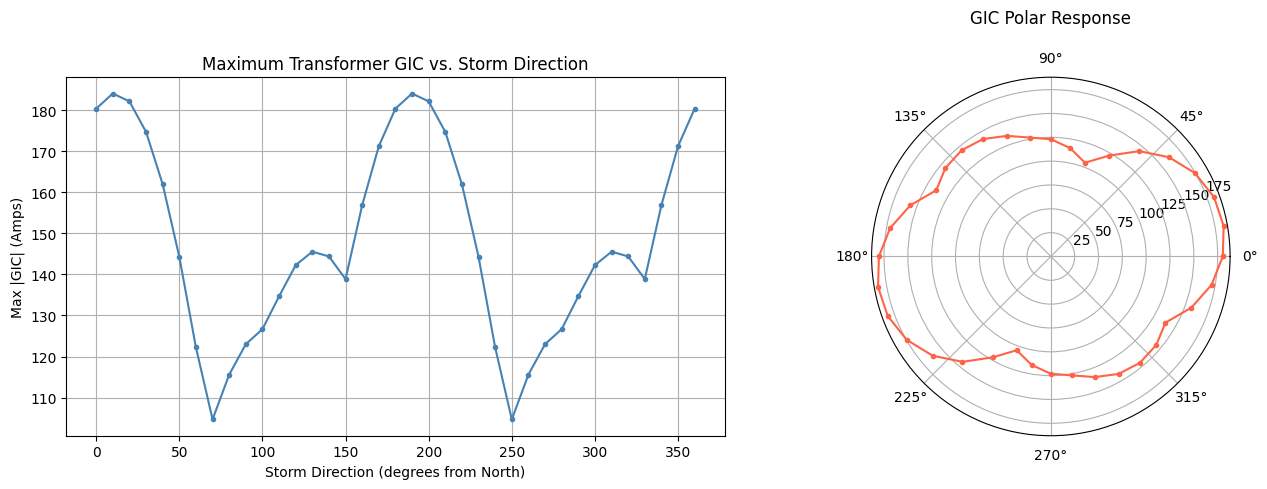

Worst-case direction: 10 degrees
Worst-case max GIC: 184.07 Amps


In [18]:
plot_direction_sensitivity(directions, max_gics,
                           title='Maximum Transformer GIC vs. Storm Direction')

## 8. Exporting to B3D Format

The B3D binary format stores spatially-varying E-field data for import into PowerWorld's
GIC engine. We export our latitude-varying field to B3D and verify the round-trip.

In [19]:
# Create B3D from our mesh-grid E-field
b3d = B3D.from_mesh(
    long=lons,
    lat=lats,
    ex=Ex_varying,
    ey=Ey_varying,
    comment="Latitude-varying E-field example"
)

print(f"B3D object:")
print(f"  Grid dimensions: {b3d.grid_dim}")
print(f"  Location points: {len(b3d.lat)}")
print(f"  Time steps: {len(b3d.time)}")
print(f"  Ex shape: {b3d.ex.shape}")
print(f"  Ey shape: {b3d.ey.shape}")

# Write to file
b3d.write_b3d_file("efield_geographic.b3d")
print("\nWritten to efield_geographic.b3d")

B3D object:
  Grid dimensions: [40, 30]
  Location points: 1200
  Time steps: 1
  Ex shape: (1, 1200)
  Ey shape: (1, 1200)

Written to efield_geographic.b3d


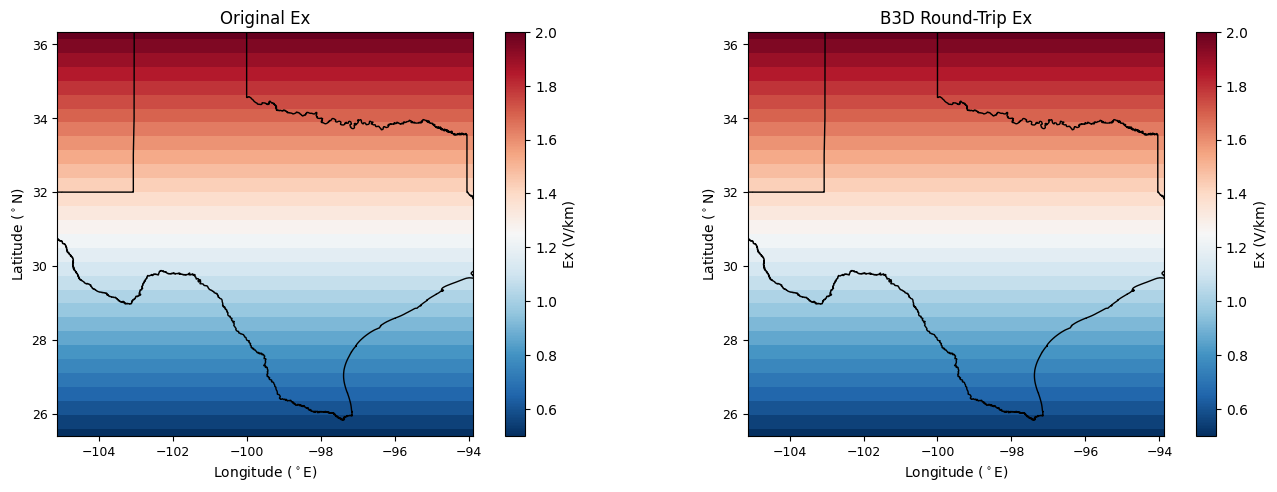

In [ ]:
b3d_loaded = B3D("efield_geographic.b3d")
plot_b3d_roundtrip(LON, LAT, b3d.ex, b3d_loaded.ex, SHAPE, ny, nx)

## Summary

This notebook demonstrated the full GIC geographic analysis workflow:

1. **Geographic extent** extracted from bus/substation coordinates
2. **Grid2D** constructed in lat/lon space with incidence-matrix-based operators
3. **E-field patterns** defined: uniform, spatially varying, rotational
4. **Visualizations**: magnitude heatmaps, vector fields, transmission overlays
5. **GIC computation** using PowerWorld's storm function
6. **Geographic GIC map** with transformer markers sized by GIC magnitude
7. **Direction sensitivity** polar plot revealing worst-case storm orientation
8. **B3D export** for importing custom E-fields into PowerWorld

The approach connects the mathematical tools in `esapp.utils` (Grid2D,
plot_vecfield) with the power systems analysis in `esapp.apps.gic` (model,
storm) and the geographic data in the PowerWorld case (buscoords, branch
lat/lon).